In [1]:
from copy import copy,deepcopy
from itertools import combinations
import json
import textwrap


from fisher import pvalue_npy
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

In [2]:
import requests
import requests_cache


requests_cache.install_cache(
    "pfocr_cache",
    allowable_methods=['GET', 'POST'],
    stale_if_error=False,
)
#requests_cache.remove_expired_responses()

# BTE Sleeve

TLDR: skip ahead to the "View TRAPI results and figures" section to see figures by TRAPI result and TRAPI results by figure.

Some queries result in an explosion of the number of results. This is bad for performance of the server and also not very useful to the user. This notebook explores using PFOCR as a "compression sleeve" to dampen these types of explosions. I don't have a CC-licensed image of a compression sleeve, so instead here's an image of a heat-shrink tube.

<a title="oomlout, CC BY-SA 2.0 &lt;https://creativecommons.org/licenses/by-sa/2.0&gt;, via Wikimedia Commons" href="https://commons.wikimedia.org/wiki/File:HESH-06-L-STAN-01_(9601242883).jpg"><img width="512" alt="HESH-06-L-STAN-01 (9601242883)" src="https://upload.wikimedia.org/wikipedia/commons/thumb/d/d3/HESH-06-L-STAN-01_%289601242883%29.jpg/512px-HESH-06-L-STAN-01_%289601242883%29.jpg"></a>

Note BTE Sleeve currently only works on queries with nodes of categories supported by PFOCR, e.g., `biolink:Gene`, `biolink:SmallMolecule`, `biolink:Disease`. TODO: update the Fisher's Exact test to work with node categories not in PFOCR.

## Get BTE TRAPI Results

In [3]:
query = {
    "message": {
        "query_graph": {
            "edges": {
                "e0": {
                    "subject": "n0",
                    "object": "n1",
                    "predicates": [
                        "biolink:entity_regulates_entity",
                        "biolink:genetically_interacts_with"
                    ]
                },
                "e1": {
                    "subject": "n1",
                    "object": "n2",
                    "predicates": [
                        "biolink:related_to"
                    ]
                }
            },
            "nodes": {
                "n0": {
                    "ids": [
                        "NCBIGene:5872"
                    ],
                    "categories": [
                        "biolink:Gene"
                    ]
                },
                "n1": {
                    "categories": [
                        "biolink:Gene"
                    ],
                },
                "n2": {
                    "categories": [
                        "biolink:SmallMolecule"
                    ]
                }
            }
        }
    }
}

trapi_response = requests.post("http://localhost:3000/v1/query", json=query)
#trapi_response = requests.post("https://api.bte.ncats.io/v1/query", json=query)
#trapi_response = requests.post("https://arax.ncats.io/api/rtxkg2/v1.2/query", json=query)
#trapi_response = requests.post("https://arax.ncats.io/api/arax/v1.2/query", json=query)
print(trapi_response.status_code)
if trapi_response.status_code != 200:
    raise Exception(trapi_response.text)
if trapi_response.from_cache:
    print(f"got response from cache")

trapi_message = trapi_response.json()["message"]

if len(trapi_message["results"]) == 0:
    raise Exception(f'No results returned')

200
got response from cache


Analyze this GraphML file in Cytoscape: ./bte_sleeve_query_template.graphml


{('n0',
  'n1'): Text(0.48768536731014417, 0.49969156770226864, 'biolink:entity_regulates_entity\nbiolink:genetically_interacts_with'),
 ('n1', 'n2'): Text(-0.4879853217817037, -0.5, 'biolink:related_to')}

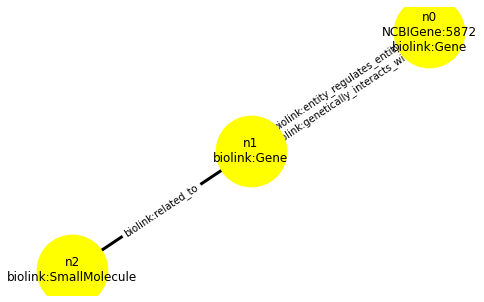

In [4]:
from collections import defaultdict


G = nx.Graph()
query_node_labels = {}
for k, v in query['message']['query_graph']['nodes'].items():
    node_ids = v.get('ids', [])
    node_categories = v.get('categories', [])
    G.add_node(k, categories=', '.join(node_categories))
    query_node_labels[k] = '\n'.join([k] + node_ids + node_categories)
    #G.add_node(k, color='red')

query_edge_labels = {}
q_node_id_keys = set(['object', 'subject'])
for q_edge_id,edge_v in query['message']['query_graph']['edges'].items():
    for predicate in edge_v['predicates']:
        G.add_edge(edge_v['subject'], edge_v['object'], predicate=predicate)
    #G.add_edge(edge_v['subject'], edge_v['object'], predicates=', '.join(edge_v['predicates']))
    #G.add_edge(edge_v['subject'], edge_v['object'], predicates=[1,2,3])
    #G.add_edge(edge_v['subject'], edge_v['object'])
    query_edge_labels[(edge_v['subject'], edge_v['object'])] = '\n'.join(edge_v['predicates'])
    
query_template_f = './bte_sleeve_query_template.graphml'
print(f'Analyze this GraphML file in Cytoscape: {query_template_f}')
nx.write_graphml(G, query_template_f)

options = {
    'node_color': 'yellow',
    'node_size': 5000,
    'edge_color': 'black',
    'width': 3,
}
query_template_layout = nx.spring_layout(G)
nx.draw(G, pos=query_template_layout, **options)
nx.draw_networkx_labels(G, query_template_layout, labels=query_node_labels, font_size=12,
                        font_color='k', font_family='sans-serif',
                        font_weight='normal', alpha=None, bbox=None, horizontalalignment='center',
                        verticalalignment='center', ax=None, clip_on=False)
nx.draw_networkx_edge_labels(G, pos=query_template_layout,
                             edge_labels=query_edge_labels,
                             label_pos=0.5, 
                             font_size=10, font_color='k', font_family='sans-serif',
                             font_weight='normal', alpha=None, bbox=None, horizontalalignment='center',
                             verticalalignment='center', ax=None, rotate=True, clip_on=True)

In [5]:
# NOTE: we're including categories specified in the query template
# in the next cell, and in a cell further down, we're also including
# any categories from the TRAPI results.
#
# TODO: Some categories are supersets of others. Should we handle
# this systematically?

curie_categories = set()
for v in query["message"]["query_graph"]["nodes"].values():
    if "categories" in v:
        for category in v["categories"]:
            curie_categories.add(category)

In [6]:
# for genes/gene products, chemicals and diseases
preferred_prefixes = set(["NCBIGene", "MESH"])
unified_names = set()
unified_curies = set()
unification_failed_curies = set()
unified_prefixes = set()
all_prefixes = set()
curie_to_name = dict()
curie_to_unified_curie = dict()
for k, v in trapi_message["knowledge_graph"]["nodes"].items():
    name = v["name"]
    for category in v["categories"]:
        curie_categories.add(category)
        
    for a in v["attributes"]:
        if a["attribute_type_id"] == "biolink:xref":
            curies = a["value"]
            
            # k should always be one of the curies
            if not k in curies:
                raise Exception(f"key {k} not in {curies}")
            
            unified_curie = None
            intersecting_unified_curies = unified_curies.intersection(set(curies))
            if len(intersecting_unified_curies) > 1:
                raise Exception(f"matching multiple: {k} to {list(intersecting_unified_curies)}")
            elif len(intersecting_unified_curies) == 1:
                unified_curie = list(intersecting_unified_curies)[0]
            else:
                # get curie for preferred prefix. usually this is k, but not always.
                for curie in curies:
                    [prefix, identifier] = curie.split(":")
                    if prefix in preferred_prefixes:
                        unified_curie = curie
                        unified_curies.add(unified_curie)
                        break
                        
            if not unified_curie:
                if k in curie_to_unified_curie:
                    unified_curie = curie_to_unified_curie[k]
                else:
                    unification_failed_curies.add(k)
                    break
                    
                #raise Exception(f"failed to find a unified curie for {k} in {curies}")
                
            [unified_prefix, unified_identifier] = unified_curie.split(":")
            unified_prefixes.add(unified_prefix)
            
            for curie in curies:
                [prefix, identifier] = curie.split(":")
                all_prefixes.add(prefix)
                if not curie in curie_to_unified_curie:
                    curie_to_unified_curie[curie] = unified_curie
                if not curie in curie_to_name:
                    curie_to_name[curie] = name
                    unified_names.add(name)
                elif curie_to_name[curie] != name:
                    print(f"curie {curie} has multiple primary names: {curie_to_name[curie]} and {name}")
                    #raise Exception(f"curie{curie} has multiple names: {curie_to_name[curie]} and {name}")


#print(f'curie_categories: {curie_categories}')
#print("")
#print(f"curie_to_name key count: {len(curie_to_name.keys())}")
#print(f"curie_to_unified_curie key count: {len(curie_to_unified_curie.keys())}")
#print("")
print("all CURIE prefixes found:")
print(all_prefixes)
print("")
print("unified CURIE prefixes found:")
print(unified_prefixes)
print("")
print(f"failed to unify {len(unification_failed_curies)} CURIEs")

curie UMLS:C0903898 has multiple primary names: NATEGLINIDE and nateglinide
curie UMLS:C0021641 has multiple primary names: Iletin and Insulin
all CURIE prefixes found:
{'KEGG.COMPOUND', 'PUBCHEM.COMPOUND', 'CAS', 'HGNC', 'INCHIKEY', 'ENSEMBL', 'MESH', 'GTOPDB', 'UNII', 'UniProtKB', 'DrugCentral', 'DRUGBANK', 'CHEMBL.COMPOUND', 'OMIM', 'UMLS', 'CHEBI', 'NCBIGene', 'HMDB', 'PR'}

unified CURIE prefixes found:
{'NCBIGene', 'MESH'}

failed to unify 886 CURIEs


In [7]:
columns = []
q_node_id_keys = set(["object", "subject"])
q_node_ids = []
q_edge_ids = []
for q_edge_id,edge_v in query["message"]["query_graph"]["edges"].items():
    q_edge_ids.append(q_edge_id)
    q_node_id_found = False
    for k,v in edge_v.items():
        if (k in q_node_id_keys) and (type(v) is str):
            if v not in columns:
                q_node_ids.append(v)
                columns.append(v)
            if not q_node_id_found:
                q_node_id_found = True
                columns.append(q_edge_id)
                
query_nodes_with_ids = set()
for k, v in query['message']['query_graph']['nodes'].items():
    node_ids = v.get('ids', [])
    if node_ids:
        query_nodes_with_ids.add(k)
                
for q_node_id in q_node_ids:
    columns.append(f"{q_node_id}_curie")
    columns.append(f"{q_node_id}_unified_curie")
    
columns.append("trapi_result_curie_combo")

trapi_result_columns = []
for i in range(len(q_node_ids)):
    trapi_result_columns.append(q_node_ids[i])
    if i < len(q_edge_ids):
        trapi_result_columns.append(q_edge_ids[i])

unified_curie_columns = []
for q_node_id in q_node_ids:
    unified_curie_columns.append(f"{q_node_id}_unified_curie")

In [8]:
trapi_results = trapi_message["results"]

result_row_data = []
for trapi_result in trapi_results:
    curie_to_qnode_ids = dict()
    for qnode_id, entries in trapi_result["node_bindings"].items():
        for entry in entries:
            curie = entry["id"]
            if curie not in curie_to_qnode_ids:
                curie_to_qnode_ids[curie] = []
            curie_to_qnode_ids[curie].append(qnode_id)
        
    row_data_template = dict()
    q_edge_id_to_predicates = dict()
    trapi_result_curies = set()
    for qedge_id, entries in trapi_result["edge_bindings"].items():
        for entry in entries:
            curie = entry["id"]
            kg_entry = trapi_message["knowledge_graph"]["edges"][curie]
            subject_curie = kg_entry["subject"]
            object_curie = kg_entry["object"]
            predicate_curie = kg_entry["predicate"]
            [predicate_prefix, predicate_identifier] = predicate_curie.split(":")
            
            if qedge_id not in q_edge_id_to_predicates:
                q_edge_id_to_predicates[qedge_id] = set()
            q_edge_id_to_predicates[qedge_id].add(predicate_identifier)

            for curie in [subject_curie, object_curie]:
                for qnode_id in curie_to_qnode_ids[curie]:
                    if curie in curie_to_unified_curie:
                        unified_curie = curie_to_unified_curie[curie]
                    else:
                        break

                    name = curie_to_name[curie]
                    row_data_template[qnode_id] = name

                    trapi_result_curies.add(unified_curie)
                    row_data_template[qnode_id + "_curie"] = curie
                    row_data_template[qnode_id + "_unified_curie"] = unified_curie
                    
    if len(trapi_result_curies) != len(q_node_ids):
        #print(f'skipping {list(curie_to_qnode_ids.keys())}')
        continue
        
    row_data_template["trapi_result_curie_combo"] = tuple(sorted(trapi_result_curies))
    q_edge_ids_processed = set()
    row_datas = [row_data_template]
    for q_edge_id,predicates in q_edge_id_to_predicates.items():
        next_row_datas = []
        for row_data in row_datas:
            for predicate in predicates:
                next_row_data = deepcopy(row_data)
                next_row_data[q_edge_id] = predicate
                next_row_datas.append(
                    next_row_data 
                )
        row_datas = next_row_datas
    result_row_data += row_datas
        
print("warning: predicate direction(s) may be switched")
results_df = pd.DataFrame.from_records(result_row_data, columns=columns).drop_duplicates()
results_df

,n0,e0,n1,e1,n2,n0_curie,n0_unified_curie,n1_curie,n1_unified_curie,n2_curie,n2_unified_curie,trapi_result_curie_combo
0,RAB13,entity_positively_regulates_entity,RAB18,entity_positively_regulated_by_entity,WATER,NCBIGene:5872,NCBIGene:5872,NCBIGene:22931,NCBIGene:22931,CHEMBL.COMPOUND:CHEMBL1098659,MESH:D014867,"(MESH:D014867, NCBIGene:22931, NCBIGene:5872)"
1,RAB13,entity_positively_regulates_entity,RAB18,entity_negatively_regulated_by_entity,WATER,NCBIGene:5872,NCBIGene:5872,NCBIGene:22931,NCBIGene:22931,CHEMBL.COMPOUND:CHEMBL1098659,MESH:D014867,"(MESH:D014867, NCBIGene:22931, NCBIGene:5872)"
2,RAB13,entity_positively_regulates_entity,RAB18,entity_positively_regulated_by_entity,Isopropyl-beta-D-thiogalactopyranoside,NCBIGene:5872,NCBIGene:5872,NCBIGene:22931,NCBIGene:22931,PUBCHEM.COMPOUND:656894,MESH:D007544,"(MESH:D007544, NCBIGene:22931, NCBIGene:5872)"
3,RAB13,entity_positively_regulates_entity,RAB18,entity_positively_regulated_by_entity,Trichostatin A,NCBIGene:5872,NCBIGene:5872,NCBIGene:22931,NCBIGene:22931,PUBCHEM.COMPOUND:444732,MESH:C012589,"(MESH:C012589, NCBIGene:22931, NCBIGene:5872)"
4,RAB13,entity_positively_regulates_entity,RAB18,entity_positively_regulated_by_entity,Mannitol,NCBIGene:5872,NCBIGene:5872,NCBIGene:22931,NCBIGene:22931,PUBCHEM.COMPOUND:6251,MESH:D008353,"(MESH:D008353, NCBIGene:22931, NCBIGene:5872)"
...,...,...,...,...,...,...,...,...,...,...,...,...
6125,RAB13,genetically_interacts_with,TGFBR1,coexists_with,5' Flanking Region,NCBIGene:5872,NCBIGene:5872,NCBIGene:7046,NCBIGene:7046,UMLS:C0949645,MESH:D024506,"(MESH:D024506, NCBIGene:5872, NCBIGene:7046)"
6126,RAB13,genetically_interacts_with,TGFBR1,coexists_with,"1,3,4,6-Tetra-O-acetyl-2-azido-2-deoxy-beta-D-...",NCBIGene:5872,NCBIGene:5872,NCBIGene:7046,NCBIGene:7046,PUBCHEM.COMPOUND:133445,MESH:C070423,"(MESH:C070423, NCBIGene:5872, NCBIGene:7046)"
6127,RAB13,genetically_interacts_with,TGFBR1,increases_response_to,Thioacetamide,NCBIGene:5872,NCBIGene:5872,NCBIGene:7046,NCBIGene:7046,PUBCHEM.COMPOUND:2723949,MESH:D013853,"(MESH:D013853, NCBIGene:5872, NCBIGene:7046)"
6128,RAB13,genetically_interacts_with,TGFBR1,affects_response_to,Thioacetamide,NCBIGene:5872,NCBIGene:5872,NCBIGene:7046,NCBIGene:7046,PUBCHEM.COMPOUND:2723949,MESH:D013853,"(MESH:D013853, NCBIGene:5872, NCBIGene:7046)"


Unique CURIE count per query node:

In [9]:
for q_node_id in q_node_ids:
    print(f'{q_node_id}: {len(set(results_df[q_node_id]))}')

n0: 1
n1: 12
n2: 1347


Total results count (excluding any that couldn't be unified):

In [10]:
len(set(results_df["trapi_result_curie_combo"]))

3158

That's too too high for a researcher to efficiently go through manually. Let's try filtering to make that more manageable.

## Match up BTE TRAPI Results & PFOCR

We're going to try using PFOCR to filter and prioritize the results.

First we need to get the PFOCR Data. We could get it from the API, but for now, we'll just go ahead and download the entire JSON file we gave to BTE.

In [11]:
pfocr_url = "https://www.dropbox.com/s/1f14t5zaseocyg6/bte_chemicals_diseases_genes.ndjson?dl=1"
pfocr_request = requests.get(pfocr_url)
print(f"status_code: {pfocr_request.status_code}")
if pfocr_request.status_code != 200:
    print(pfocr_request.text)

status_code: 200


In [12]:
curies_to_figure_ids = {}
figure_id_to_curies = {}
figure_id_to_pfocr_result = {}
for line in pfocr_request.text.splitlines():
    pfocr_result = json.loads(line)
    figure_id = pfocr_result["_id"]

    curies = set()
    for identifier in pfocr_result["associatedWith"]["mentions"]["chemicals"]["mesh"]:
        curie = "MESH:" + identifier
        if curie in curie_to_unified_curie:
            unified_curie = curie_to_unified_curie[curie]
            curies.add(unified_curie)
        else:
            #print(f"{curie} not in list")
            # this curie isn't in the BTE results, but we'll add an item for
            # the purpose of the denominator in jaccard/containment cals
            curies.add(curie)
    for identifier in pfocr_result["associatedWith"]["mentions"]["diseases"]["mesh"]:
        curie = "MESH:" + identifier
        if curie in curie_to_unified_curie:
            unified_curie = curie_to_unified_curie[curie]
            curies.add(unified_curie)
        else:
            #print(f"{curie} not in list")
            # this curie isn't in the BTE results, but we'll add an item for
            # the purpose of the denominator in jaccard/containment cals
            curies.add(curie)
    for identifier in pfocr_result["associatedWith"]["mentions"]["genes"]["ncbigene"]:
        curie = "NCBIGene:" + identifier
        if curie in curie_to_unified_curie:
            unified_curie = curie_to_unified_curie[curie]
            curies.add(unified_curie)
        else:
            #print(f"{curie} not in list")
            # this curie isn't in the BTE results, but we'll add an item for
            # the purpose of the denominator in jaccard/containment cals
            curies.add(curie)

    figure_id_to_pfocr_result[figure_id] = pfocr_result
    figure_id_to_curies[figure_id] = curies

    curies_key = tuple(sorted(curies))
    if curies_key not in curies_to_figure_ids:
        curies_to_figure_ids[curies_key] = []
    curies_to_figure_ids[curies_key].append(figure_id)

In [13]:
from SetSimilaritySearch import SearchIndex

# the reference sets are supposed to be from PFOCR only
reference_sets = list()
for curies in set(curies_to_figure_ids.keys()):
    reference_sets.append(set(curies))
# but in order to calculate the scores correctly,
# the SetSimilaritySearch library requires that
# every curie from the bte results need to be
# mentioned at least once in the reference set.
# That's the only reason we add them below, as
# one large set.

unified_curie_columns = [
    q_node_id + "_unified_curie" for q_node_id in q_node_ids
]

trapi_result_curie_combos = set()
for i, df in results_df[unified_curie_columns].drop_duplicates().iterrows():
    trapi_result_curies = []
    for unified_curie_column in unified_curie_columns:
        trapi_result_curies.append(
            df[unified_curie_column]
        )
    trapi_result_curie_combos.add(tuple(sorted(
        trapi_result_curies
    )))
    
reference_set = set()
for trapi_result_curie_combo in trapi_result_curie_combos:
    reference_set |= set(trapi_result_curie_combo)
reference_sets.append(reference_set)

matchable_node_min = 2
matchable_node_count = len(q_node_ids)
index = SearchIndex(reference_sets, similarity_func_name="containment", 
    similarity_threshold=matchable_node_min/matchable_node_count)

trapi_figure_overlap_rows = []
for trapi_result_curie_combo in trapi_result_curie_combos:
    trapi_curies = set(trapi_result_curie_combo)
    results = index.query(trapi_curies)
    for result in results:
        figure_curie_combos = reference_sets[result[0]]
        figure_curie_key = tuple(sorted(figure_curie_combos))
        
        # needed to not match bte results to themselves
        if figure_curie_key in curies_to_figure_ids:
            figure_ids = curies_to_figure_ids[figure_curie_key]
        else:
            continue
            
        score = result[1]
        
        common_curies = trapi_curies.intersection(figure_curie_combos)
        for figure_id in figure_ids:
            pfocr_result = figure_id_to_pfocr_result[figure_id]
            trapi_figure_overlap_rows.append({
                "figure_id": figure_id,
                "figure_url": pfocr_result["associatedWith"]["figureUrl"],
                "figure_title": pfocr_result["associatedWith"]["title"],
                "trapi_result_curie_combo": trapi_result_curie_combo,
                "figure_curie_combo": figure_curie_key,
                "overlap_curie_combo": tuple(sorted(common_curies)),
                "score": score,
            })


trapi_figure_overlap_df = pd.DataFrame.from_records(trapi_figure_overlap_rows)
trapi_figure_overlap_df

,figure_id,figure_url,figure_title,trapi_result_curie_combo,figure_curie_combo,overlap_curie_combo,score
0,PMC7884075__elife-58615-fig4.jpg,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,GWAS hits in the IGF-1 pathway,"(MESH:D015365, NCBIGene:3630, NCBIGene:5872)","(MESH:D009584, NCBIGene:10000, NCBIGene:10890,...","(NCBIGene:3630, NCBIGene:5872)",0.666667
1,PMC6406872__cells-08-00192-g003.jpg,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...,Structural hotspots and signaling pathways tha...,"(MESH:D015365, NCBIGene:3630, NCBIGene:5872)","(NCBIGene:1000, NCBIGene:10000, NCBIGene:10050...","(NCBIGene:3630, NCBIGene:5872)",0.666667
2,PMC5518130__12864_2017_3907_Fig4_HTML.jpg,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,Differently expressed protein-coding genes and...,"(MESH:D015365, NCBIGene:3630, NCBIGene:5872)","(MESH:C031143, MESH:D000105, MESH:D000214, MES...","(NCBIGene:3630, NCBIGene:5872)",0.666667
3,PMC6472122__MMR-19-05-3564-g04.jpg,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...,Transfer RNA-derived fragment target genes in ...,"(MESH:D015365, NCBIGene:3630, NCBIGene:5872)","(MESH:C031143, MESH:C045651, MESH:D000105, MES...","(NCBIGene:3630, NCBIGene:5872)",0.666667
4,PMC5546324__nihms866088f6.jpg,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,AKT/PKB Signaling: Navigating the Network,"(MESH:D015365, NCBIGene:3630, NCBIGene:5872)","(MESH:D000249, MESH:D005947, NCBIGene:10000, N...","(NCBIGene:3630, NCBIGene:5872)",0.666667
...,...,...,...,...,...,...,...
66865,PMC6895093__41598_2019_54408_Fig15_HTML.jpg,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...,"Apoptosis adapted from KEGG (ID: hsa04210), th...","(MESH:D006160, NCBIGene:3630, NCBIGene:5872)","(MESH:C047902, MESH:D005947, MESH:D006695, MES...","(NCBIGene:3630, NCBIGene:5872)",0.666667
66866,PMC3740206__nihms-424399-f0004.jpg,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...,Exocyst Sec10 is Involved in Basolateral Prote...,"(MESH:D006160, NCBIGene:3630, NCBIGene:5872)","(MESH:C117212, MESH:D006160, NCBIGene:10890, N...","(MESH:D006160, NCBIGene:5872)",0.666667
66867,PMC5663315__nihms889033f1.jpg,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,Schematic representation of the mTOR signaling...,"(MESH:D006160, NCBIGene:3630, NCBIGene:5872)","(MESH:C030986, MESH:C060980, MESH:D000255, MES...","(MESH:D006160, NCBIGene:3630)",0.666667
66868,PMC6472122__MMR-19-05-3564-g04.jpg,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...,Transfer RNA-derived fragment target genes in ...,"(MESH:D006160, NCBIGene:3630, NCBIGene:5872)","(MESH:C031143, MESH:C045651, MESH:D000105, MES...","(NCBIGene:3630, NCBIGene:5872)",0.666667


### trapi_curie_combo_count_by_figure_df

In [14]:
trapi_curie_combo_count_by_figure_df = trapi_figure_overlap_df[
    ["figure_id", "trapi_result_curie_combo"]
].rename(columns={
    "trapi_result_curie_combo": "trapi_curie_combo_count"
}).groupby("figure_id").count().sort_values(
    by="trapi_curie_combo_count", ascending=False)
trapi_curie_combo_count_by_figure_df

,trapi_curie_combo_count
figure_id,
PMC6406872__cells-08-00192-g003.jpg,1470
PMC6472122__MMR-19-05-3564-g04.jpg,1182
PMC5518130__12864_2017_3907_Fig4_HTML.jpg,1175
PMC6770969__genes-10-00728-g006.jpg,1165
PMC6895093__41598_2019_54408_Fig15_HTML.jpg,1150
...,...
PMC4623426__fncel-09-00426-g0004.jpg,1
PMC4623426__fncel-09-00426-g0003.jpg,1
PMC4620423__WJSC-7-1150-g001.jpg,1


### Figure count by TRAPI CURIE combo

In [15]:
trapi_figure_overlap_df[
    ["trapi_result_curie_combo", "figure_id"]
].rename(columns={
    "figure_id": "figure_count"
}).groupby("trapi_result_curie_combo").count().sort_values(
    by="figure_count", ascending=False)

,figure_count
trapi_result_curie_combo,
"(NCBIGene:4088, NCBIGene:4089, NCBIGene:5872)",1790
"(MESH:D002784, NCBIGene:22931, NCBIGene:5872)",192
"(MESH:D004317, NCBIGene:22931, NCBIGene:5872)",191
"(MESH:D003561, NCBIGene:22931, NCBIGene:5872)",191
"(MESH:C423915, NCBIGene:22931, NCBIGene:5872)",191
...,...
"(MESH:C085911, NCBIGene:5872, NCBIGene:6789)",1
"(MESH:C085911, NCBIGene:5872, NCBIGene:7316)",1
"(MESH:C554092, NCBIGene:5147, NCBIGene:5872)",1


### Figure containment score by TRAPI CURIE combo

This can yield the same order of results, but if one TRAPI result has higher overlap of CURIEs with the figure(s), that TRAPI result could leapfrog over another TRAPI result that overlaps with more figures but at lower containment scores.

Note the weakness of containment is it doesn't take into account the number of CURIEs in the figure.

In [16]:
trapi_result_figure_score_df = trapi_figure_overlap_df[
    ["trapi_result_curie_combo", "score"]
].rename(
    columns={"score": "cumulative_trapi_result_curie_combo_figure_score"}
).groupby("trapi_result_curie_combo").sum().sort_values(
    by="cumulative_trapi_result_curie_combo_figure_score", ascending=False)
trapi_result_figure_score_df

,cumulative_trapi_result_curie_combo_figure_score
trapi_result_curie_combo,
"(NCBIGene:4088, NCBIGene:4089, NCBIGene:5872)",1195.333333
"(MESH:D002784, NCBIGene:22931, NCBIGene:5872)",139.666667
"(MESH:D019821, NCBIGene:201475, NCBIGene:5872)",131.000000
"(MESH:C031143, NCBIGene:22931, NCBIGene:5872)",128.333333
"(MESH:D013395, NCBIGene:22931, NCBIGene:5872)",128.000000
...,...
"(MESH:C085911, NCBIGene:5872, NCBIGene:6789)",0.666667
"(MESH:C085911, NCBIGene:5872, NCBIGene:7316)",0.666667
"(MESH:C554092, NCBIGene:5147, NCBIGene:5872)",0.666667


In [17]:
results_with_figures_df = trapi_figure_overlap_df.merge(
    results_df,
    on="trapi_result_curie_combo",
    how="left").merge(
    trapi_result_figure_score_df.reset_index(),
    on="trapi_result_curie_combo",
    how="left",
    validate="many_to_one"
).merge(
    trapi_curie_combo_count_by_figure_df.reset_index().rename(columns={
        "trapi_curie_combo_count": "trapi_curie_combo_count_by_figure"
    }),
    on="figure_id",
    how="left",
    validate="many_to_one"
).sort_values(
    by="cumulative_trapi_result_curie_combo_figure_score", ascending=False
)

## Fisher's Exact Test

Let's quantify the match up between figures and TRAPI results.

In [18]:
all_genes = set()
gene_instance_count = 0
all_chemicals = set()
chemical_instance_count = 0
all_diseases = set()
disease_instance_count = 0
for figure_id, pfocr_result in figure_id_to_pfocr_result.items():
    genes = pfocr_result["associatedWith"]["mentions"]["genes"]["ncbigene"]
    for gene in genes:
        gene_instance_count += 1
        all_genes.add(gene)

    chemicals = pfocr_result["associatedWith"]["mentions"]["chemicals"]["mesh"]
    for chemical in chemicals:
        chemical_instance_count += 1
        all_chemicals.add(chemical)

    diseases = pfocr_result["associatedWith"]["mentions"]["diseases"]["mesh"]
    for disease in diseases:
        disease_instance_count += 1
        all_diseases.add(disease)

print("total instance counts:")
print(f'  chemicals: {chemical_instance_count}')
print(f'  diseases: {disease_instance_count}')
print(f'  genes: {gene_instance_count}')

print("")

print("unique counts:")
print(f'  chemicals: {len(all_chemicals)}')
print(f'  diseases: {len(all_diseases)}')
print(f'  genes: {len(all_genes)}')

print("")

curie_category_to_curies = {
    "biolink:ChemicalEntity": all_chemicals,
    "biolink:SmallMolecule": all_chemicals,
    "biolink:Disease": all_diseases,
    "biolink:Gene": all_genes,
}


all_figure_curies = set()
for curie_category in set(curie_category_to_curies.keys()).intersection(curie_categories):
    all_figure_curies |= curie_category_to_curies[curie_category]
all_figure_curie_count = len(all_figure_curies)

print(f'M for Fisher Exact test: {all_figure_curie_count}')
print('TODO: should this number be based on what is in BTE/TRAPI?')

total instance counts:
  chemicals: 275456
  diseases: 20465
  genes: 1369680

unique counts:
  chemicals: 14482
  diseases: 1430
  genes: 14253

M for Fisher Exact test: 28735
TODO: should this number be based on what is in BTE/TRAPI?


See [this contingency table](https://docs.google.com/spreadsheets/d/1d-48R5N0auuKXSLJ7oZ2E_ldO26Z5KiEH3AQx5kDrC4/edit#gid=0):

|      |  |
| ----------- | ----------- |
| trapi_curies_in_pwy      | q_node_id_count - trapi_curies_in_pwy       |
| curies_in_pwy - trapi_curies_in_pwy   | 28735 - curies_in_pwy - q_node_id_count + trapi_curies_in_pwy        |

and the [scipy documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.fisher_exact.html):

|      |  |
| ----------- | ----------- |
| x      | n - x       |
| N - x   | M - (n + N) + x        |

and the [fisher documentation](https://pypi.org/project/fisher/).

In [19]:
# trapi_curies_in_pwy
# x
results_with_figures_df["yes_trapi_yes_pwy"] = (
    results_with_figures_df["overlap_curie_combo"].map(len)
)

# q_node_id_count - trapi_curies_in_pwy
# n - x
results_with_figures_df["yes_trapi_no_pwy"] = (
    len(q_node_ids) - results_with_figures_df["yes_trapi_yes_pwy"]
)

# curies_in_pwy - trapi_curies_in_pwy
# N - x
results_with_figures_df["no_trapi_yes_pwy"] = (
    results_with_figures_df["figure_curie_combo"].map(len) - 
    results_with_figures_df["yes_trapi_yes_pwy"]
)

# 28735 - curies_in_pwy - q_node_id_count + trapi_curies_in_pwy
# M - (n + N) + x
results_with_figures_df["no_trapi_no_pwy"] = (
    all_figure_curie_count -
    results_with_figures_df["figure_curie_combo"].map(len) -
    len(q_node_ids) +
    results_with_figures_df["yes_trapi_yes_pwy"]
)

In [20]:
# see https://stackoverflow.com/a/58661068/5354298

_, _, twosided = pvalue_npy(
    results_with_figures_df["yes_trapi_yes_pwy"].to_numpy('uint'),
    results_with_figures_df["yes_trapi_no_pwy"].to_numpy('uint'),
    results_with_figures_df["no_trapi_yes_pwy"].to_numpy('uint'),
    results_with_figures_df["no_trapi_no_pwy"].to_numpy('uint'),
)
# TODO: do we need the odds ratio?
#odds = (
#    results_with_figures_df["yes_trapi_yes_pwy"].to_numpy('uint') *
#    results_with_figures_df["no_trapi_no_pwy"].to_numpy('uint')
#) / (
#    results_with_figures_df["yes_trapi_no_pwy"].to_numpy('uint') *
#    results_with_figures_df["no_trapi_yes_pwy"].to_numpy('uint')
#)

results_with_figures_df["p_value"] = pd.Series(twosided, index=results_with_figures_df.index)
results_with_figures_df["p_value"].sort_values()

127522    1.572988e-08
127438    1.639452e-08
127503    1.707763e-08
127338    1.777945e-08
127361    1.850024e-08
              ...     
53293     3.258204e-04
37846     4.786686e-04
37847     4.786686e-04
37848     4.786686e-04
37849     4.786686e-04
Name: p_value, Length: 135113, dtype: float64

(array([8.8841e+04, 3.8305e+04, 1.5470e+03, 4.3590e+03, 1.4740e+03,
        0.0000e+00, 5.8300e+02, 0.0000e+00, 0.0000e+00, 4.0000e+00]),
 array([1.57298812e-08, 4.78810163e-05, 9.57463027e-05, 1.43611589e-04,
        1.91476876e-04, 2.39342162e-04, 2.87207448e-04, 3.35072735e-04,
        3.82938021e-04, 4.30803308e-04, 4.78668594e-04]),
 <BarContainer object of 10 artists>)

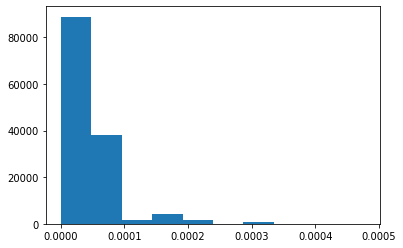

In [21]:
plt.hist(
    results_with_figures_df["p_value"]
)

## Analysis of results with vs. without BTE Sleeve

With the current query graph, requiring co-occurrence of TRAPI result CURIE(s) for particular node(s) in at least one PFOCR figure cuts down on the number of TRAPI result CURIE combos.

Note: for the number of TRAPI result CURIE combos returned, we're only including a combo when every CURIE in it can be unified. If any of the CURIEs in a combo cannot be unified, we drop that combo.

### Without BTE Sleeve

In [22]:
print(f'{len(set(results_df["trapi_result_curie_combo"]))} TRAPI results')
print(f'{len(figure_id_to_curies.keys())} figures')

3158 TRAPI results
77719 figures


### With BTE Sleeve
Below are the totals we get when we require that the CURIEs for specified query nodes must be found in at least one figure, e.g., when the CURIE for `n0` and the CURIE for `n1` must be found in the same figure at least once.

In [23]:
for i in range(2, len(q_node_ids) + 1):
    for q_node_id_combination in combinations(q_node_ids, i):
        print(f'{" & ".join(q_node_id_combination)}')
        s = pd.Series([True] * len(results_with_figures_df), index=results_with_figures_df.index)
        for q_node_id in q_node_id_combination:
            s = s & results_with_figures_df.apply(
                lambda r: r[f'{q_node_id}_unified_curie'] in r["overlap_curie_combo"], axis=1
            )
        trapi_result_count = len(set(results_with_figures_df[s == True]["trapi_result_curie_combo"]))
        print(f'  {trapi_result_count} TRAPI results')
        figure_count = len(set(results_with_figures_df[s == True]["figure_id"]))
        print(f'  {figure_count} figures')

n0 & n1
  2055 TRAPI results
  196 figures
n0 & n2
  268 TRAPI results
  105 figures
n1 & n2
  306 TRAPI results
  2144 figures
n0 & n1 & n2
  41 TRAPI results
  48 figures


## View TRAPI results and figures

Compare these results with the `results_df` table from earlier in this notebook and also with the [ARAX UI](https://arax.ncats.io/) (copy the query as JSON into the input field). You can change the definition of `cooccurrence_df` below to update which nodes must be found in at least one figure. You can also change `outer_limit` and `inner_limit` to control how many results are shown. Click a figure to view its paper.

Questions:
1. Is it useful to view figures by TRAPI result or TRAPI results by figure?
2. Does requiring co-occurrence for specific nodes like `n0` and `n2` help? Is it true that we should generally require co-occurrence by node(s) for which the user specified `ids`?
3. Does ranking by p-value help?
4. For ranking a given TRAPI result, should we take into account the number of figures that match? We're currently consider a TRAPI result to be better if it has just one figure with a slightly lower p-value than if it had 50 figures with marginally higher p-values. The cumulative containment does take into account the number of figures, but it does not take into account differences in pathway size like Fisher's Exact Test does.
5. Is it possible we'd want to uprank a TRAPI result when it matches for some nodes but downrank it when it has matches for other nodes? Example: maybe we DON'T want the TRAPI results that indicate what is already well-known for a certain hop, so we downrank when there are a large number of figures matching that hop.

In [24]:
## any two nodes
#cooccurrence_df = results_with_figures_df.sort_values(
#    "p_value"
#)

## first and any other query node
#q_node_id_combination = (q_node_ids[0],)

# first and second query nodes
#q_node_id_combination = (q_node_ids[0], q_node_ids[1])

## first and last query nodes
#q_node_id_combination = (q_node_ids[0], q_node_ids[-1])

## second and last query nodes
#q_node_id_combination = (q_node_ids[1], q_node_ids[-1])

# every query node with 'ids' specified
q_node_id_combination = query_nodes_with_ids

print(f'{" & ".join(q_node_id_combination)}')
s = pd.Series([True] * len(results_with_figures_df), index=results_with_figures_df.index)
for q_node_id in q_node_id_combination:
    s = s & results_with_figures_df.apply(
        lambda r: r[f'{q_node_id}_unified_curie'] in r["overlap_curie_combo"], axis=1
    )
cooccurrence_df = results_with_figures_df[s == True].sort_values(
    "p_value"
)

n0


#### By TRAPI result

In [25]:
from IPython.display import Image
from IPython.core.display import HTML 


outer_limit = 2
inner_limit = 5

count = 0
for trapi_result_curie_combo, one_trapi_result_curie_combo_df in cooccurrence_df.groupby(
    "trapi_result_curie_combo", sort=False
):
    trapi_curie_names = []
    for curie in one_trapi_result_curie_combo_df["trapi_result_curie_combo"].tolist()[0]:
        name = curie_to_name[curie]
        trapi_curie_names.append(name)

    cumulative_trapi_result_curie_combo_figure_score = list(set(
        one_trapi_result_curie_combo_df["cumulative_trapi_result_curie_combo_figure_score"]
    ))[0]
    
    ordered_trapi_result_curie_combo = []
    for unified_curie_column in unified_curie_columns:
        ordered_trapi_result_curie_combo.append(list(set(
            one_trapi_result_curie_combo_df[unified_curie_column]
        ))[0])

    overlap_names = []
    for curie in one_trapi_result_curie_combo_df["overlap_curie_combo"].tolist()[0]:
        name = curie_to_name[curie]
        overlap_names.append(name)

    trapi_result_rows = []
    for i,row in one_trapi_result_curie_combo_df[trapi_result_columns].drop_duplicates().iterrows():
        trapi_result_chunks = []
        for trapi_result_column in trapi_result_columns:
            row_value = row[trapi_result_column]
            if row_value in overlap_names:
                trapi_result_chunk = f'''
<span style="border: 1px orange solid; padding: 1px; border-radius: 4px;">{row_value}</span>
'''
            else:
                trapi_result_chunk = f'{row_value}'
            trapi_result_chunks.append(trapi_result_chunk)
        trapi_result_rows.append(
            f'{" - ".join(trapi_result_chunks)}'
        )
    trapi_result_row_count = len(trapi_result_rows)
    

    display(HTML(data=f'''
<div>
    <span style="font-weight: bold;">
        TRAPI result {", ".join(ordered_trapi_result_curie_combo)}
    </span> 
    <span>
        (cumulative containment: {cumulative_trapi_result_curie_combo_figure_score:.2f})
    </span>
    <div style="font-size: small;">
        {"<br>".join(trapi_result_rows)}
    </div>
</div>
'''))

    figures = []
    row_height='100px'
    for figure_id, one_figure_id_df in one_trapi_result_curie_combo_df.groupby("figure_id", sort=False):
        [pmc,filename] = figure_id.split("__")
        paper_url = f"https://www.ncbi.nlm.nih.gov/pmc/articles/{pmc}/"
        figure_url = f"https://www.ncbi.nlm.nih.gov/pmc/articles/{pmc}/bin/{filename}"
        figure_title = list(set(one_figure_id_df["figure_title"]))[0]
        figure_title_limited = textwrap.shorten(figure_title, width=45, placeholder="...")

        p_value = list(set(
            one_figure_id_df["p_value"]
        ))[0]
        score = list(set(one_figure_id_df["score"]))[0]

        # TODO: why does the commented out block below not display correctly
        # on GitHub? The figcaption appears to the right of the image.
        # The div solution below is a kludge.
        figures.append(f'''
        <div style="margin: 5px !important; padding: 5px !important; border: 1px solid slategray;>
            <figure style="margin: 5px !important;">
                <a target="_blank" href="{paper_url}">
                  <img src="{figure_url}" style="height: {row_height}">
              </a>
            </figure>
            <div style="font-size: x-small;">
                {figure_title_limited}<br>
                p-value: {p_value:.1e}, 
                containment: {score:.2}
            </div>
        </div>
        ''')
        
#        figures.append(f'''
#            <figure style="margin: 5px !important;">
#                <a target="_blank" href="{paper_url}">
#                  <img src="{figure_url}" style="height: {row_height}">
#                </a>
#                <figcaption style="font-size: small;">
#                      {figure_title_limited}<br>
#                      p-value: {p_value:.1e}, 
#                      containment: {score:.2}
#                </figcaption>
#            </figure>
#        ''')

    figure_count = len(figures)
    display(HTML(data=f'''
    <div style="display: flex; flex-flow: row wrap; text-align: center;">
    {''.join(figures[:inner_limit])}
    </div>
'''))

    if figure_count > inner_limit:
        print(f"...")
        print("")
        print(f"plus {figure_count - inner_limit} more figures")
        print("")


    count += 1
    if count >= outer_limit:
        print("...")
        print("")
        remaining = len(set(cooccurrence_df["trapi_result_curie_combo"])) - outer_limit
        print(f'plus {remaining} more TRAPI results, each with figures')
        print("")
        break

...

plus 187 more figures



...

plus 185 more figures

...

plus 2161 more TRAPI results, each with figures



#### By figure

In [26]:
from IPython.display import Image
from IPython.core.display import HTML 


outer_limit = 2
inner_limit = 3

count = 0
for figure_id, one_figure_id_df in cooccurrence_df.groupby("figure_id", sort=False):
    [pmc,filename] = figure_id.split("__")
    paper_url = f"https://www.ncbi.nlm.nih.gov/pmc/articles/{pmc}/"
    figure_url = f"https://www.ncbi.nlm.nih.gov/pmc/articles/{pmc}/bin/{filename}"
    figure_title = list(set(one_figure_id_df["figure_title"]))[0]

    display(HTML(data=f'''
<div style="border: 1px solid slategray; padding: 6px;">
    <figure style="margin: 5px !important;">
        <a target="_blank" href="{paper_url}">
          <img src="{figure_url}" style="max-height: 500px; max-width: 100%;">
        </a>
    </figure>
      {figure_title}
</div>
'''))

    trapi_results_row_sets = []
    
    for trapi_result_curie_combo, one_trapi_result_curie_combo_df in one_figure_id_df[(
        trapi_result_columns +
        unified_curie_columns +
        ["trapi_result_curie_combo", "overlap_curie_combo", "p_value", "score"]
    )].drop_duplicates().groupby("trapi_result_curie_combo", sort=False):
        overlap_names = []
        for curie in one_trapi_result_curie_combo_df["overlap_curie_combo"].tolist()[0]:
            name = curie_to_name[curie]
            overlap_names.append(name)

        trapi_results_rows = []
        for i,row in one_trapi_result_curie_combo_df.iterrows():
            trapi_result_chunks = []
            for trapi_result_column in trapi_result_columns:
                row_value = row[trapi_result_column]
                if row_value in overlap_names:
                    trapi_result_chunk = f'''
<span style="border: 1px orange solid; padding: 1px; border-radius: 4px;">{row_value}</span>
'''
                else:
                    trapi_result_chunk = f'{row_value}'
                trapi_result_chunks.append(trapi_result_chunk)
                
            trapi_results_rows.append(
                f'{" - ".join(trapi_result_chunks)}</span>'
            )
        
        ordered_trapi_result_curie_combo = []
        for unified_curie_column in unified_curie_columns:
            ordered_trapi_result_curie_combo.append(list(set(
                one_trapi_result_curie_combo_df[unified_curie_column]
            ))[0])
        
        p_value = list(set(one_trapi_result_curie_combo_df["p_value"]))[0]
        score = list(set(one_trapi_result_curie_combo_df["score"]))[0]
        trapi_results_row_sets.append(f'''
<div>
    <span style="font-weight: bold; font-size: small;">
        TRAPI result {", ".join(ordered_trapi_result_curie_combo)}
    </span> 
    (p-value: {p_value:.1e} containment: {score:.2})
    <br>
    {"<br>".join(trapi_results_rows)}
</div>
''')

    trapi_results_row_set_count = len(trapi_results_row_sets)
    display(HTML(data="<br>".join(trapi_results_row_sets[:inner_limit])))
    if trapi_results_row_set_count > inner_limit:
        print(f"...")
        print("")
        print(f"plus {trapi_results_row_set_count - inner_limit} more TRAPI results")
    print("")

    count += 1
    if count >= outer_limit:
        print("...")
        print("")
        print(f'''
plus {len(set(cooccurrence_df["figure_id"])) - outer_limit} more figures, each with TRAPI results
''')
        print("")
        break

...

plus 280 more TRAPI results



...

plus 281 more TRAPI results

...


plus 198 more figures, each with TRAPI results


